# Data Exploration

## Imports

In [3]:
import os
import cv2
import h5py
import math
import numpy as np
from PIL import Image
from scipy import misc
import random as rand
from operator import add
from six.moves import cPickle as pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches
%matplotlib inline

In [4]:
%matplotlib inline

## Indexing the training files

In [5]:
training_directory = "train/"
training_filenames = []
# Note that training_filenames is 0-indexed, but that there is no 0.png
# so, x.png = training_filenames[x-1]
for i in range(1, 33403):
    training_filenames.append(str(i)+'.png')

## Indexing the testing files

In [6]:
testing_directory = "test/"
testing_filenames = []
# Note that testing_filenames is 0-indexed, but that there is no 0.png
# so, x.png = testing_filenames[x-1]
for i in range(1, 13069):
    testing_filenames.append(str(i)+'.png')

## Displaying a Sample

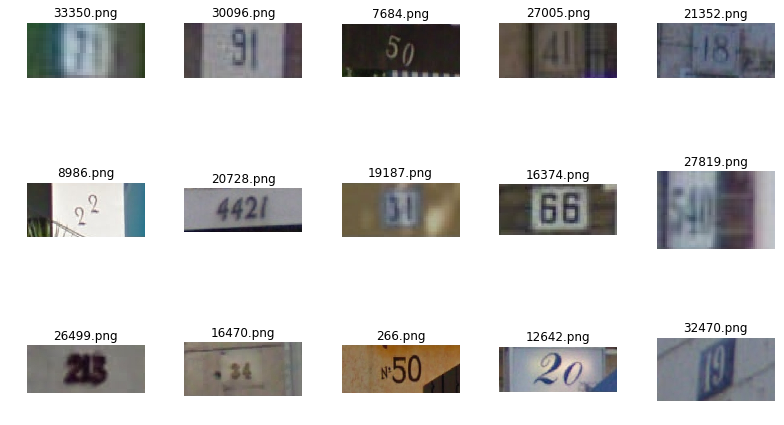

In [7]:
fig = plt.figure(figsize=(11, 7))
i = 1
rows = 3
columns = 5
for c in np.random.choice(len(training_filenames), rows * columns):
    img = mpimg.imread(training_directory + training_filenames[c])
    fig.add_subplot(rows, columns, i)
    i += 1
    plt.title(training_filenames[c])
    plt.axis("off")
    plt.imshow(img)
plt.tight_layout()
plt.show()

## Accessing the Data
The `digitStruct.mat` file included with the SVHN dataset contains the labels of the digits in the dataset images, as well as bounding boxes that describe where in the image these digits occur.

This `.mat` file is an HDF5 file format, which unfortunately I find to be too sparsely documented for me to work with (I will spare you the code boxes in which I floundered around with `<HDF5 object reference>` and other objects I didn't know how to manipulate).

Accordingly, adopting the processing pipeline from [master_yoda](https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657/3) as described in the Udacity forums, we transfer the data contained within `digitStruct.mat` into a Python dictionary for easier, more-frequently-documented manipulation.

After this (sort of lengthy) transcription has taken place, we pickle the data in accordance with master_yoda's previously-defined processing pipeline, so that on subsequent loadings of the `jupyter` notebook, we can just load the pickle file.

In [8]:
def readAndSaveMetadata(train=True):
    if train:
        directory = training_directory
        fn = "train_metadata.pickle"
    else:
        directory = testing_directory
        fn = "test_metadata.pickle"
    
    # Load the given MatLab file
    f = h5py.File(directory + 'digitStruct.mat', 'r') 
    
    # Create our empty dictionary
    metadata= {}
    metadata['height'] = []
    metadata['label'] = []
    metadata['left'] = []
    metadata['top'] = []
    metadata['width'] = []
    
    # define a function to pass to h5py's visititems() function
    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(f[obj[k][0]][0][0])
        metadata[name].append(vals)
    
    # Add information to metadata
    for item in f['/digitStruct/bbox']:
        f[item[0]].visititems(print_attrs)
    
    #print (metadata)
    # Save to a pickle file
    pickle_file = directory + fn
    try:
      pickleData = open(pickle_file, 'wb')
      pickle.dump(metadata, pickleData, pickle.HIGHEST_PROTOCOL)
      pickleData.close()
    except Exception as e:
      print ('Unable to save data to', pickle_file, ':', e)
      raise

In [9]:
#readAndSaveMetadata(train=True)
#readAndSaveMetadata(train=False)

### Loading the Pickle File

In [10]:
def loadMetadata(train=True):
    if train:
        directory = training_directory
        fn = 'train_metadata.pickle'
    else:
        directory = testing_directory
        fn = 'test_metadata.pickle'
    f = open(directory + fn, 'rb')
    return pickle.load(f)

In [11]:
training_metadata = loadMetadata(train=True)
testing_metadata = loadMetadata(train=False)

In [12]:
training_metadata.keys()

dict_keys(['height', 'width', 'top', 'label', 'left'])

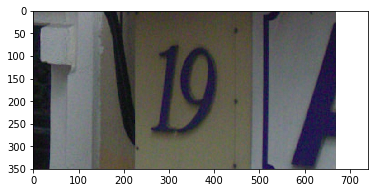

In [13]:
img = mpimg.imread("train/1.png")
plt.imshow(img)

In [14]:
training_metadata['left'][0:10]

[[246.0, 323.0],
 [77.0, 98.0],
 [17.0, 25.0],
 [57.0, 72.0],
 [52.0, 74.0],
 [28.0, 38.0],
 [35.0, 47.0],
 [17.0, 25.0, 31.0],
 [19.0, 29.0, 38.0],
 [25.0, 34.0]]

In [15]:
train_l = len(training_metadata['label'])
test_l = len(testing_metadata['label'])

In [16]:
testing_metadata['label'][rand.randint(0, test_l - 1)]

[1.0, 6.0]

In [17]:
training_metadata['label'][rand.randint(0, train_l - 1)]

[9.0, 3.0]

## Statistics

### Label Distribution
#### Training Set

In [18]:
training_labels = []
for label_group in training_metadata['label']:
    for label in label_group:
        training_labels.append(label)

In [19]:
from collections import Counter
train_digits = Counter(training_labels)
train_digits

Counter({1.0: 13861,
         2.0: 10585,
         3.0: 8497,
         4.0: 7458,
         5.0: 6882,
         6.0: 5727,
         7.0: 5595,
         8.0: 5045,
         9.0: 4659,
         10.0: 4948})

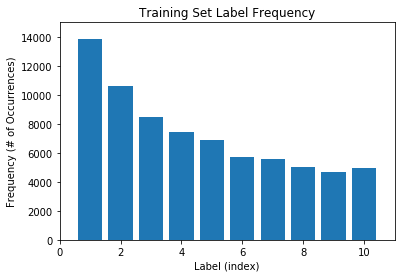

In [20]:
n, bins, patches = plt.hist(training_labels, bins=range(1,12), align='left',rwidth=0.8)

#plt.bar(list(train_digits.keys()), list(train_digits.values()), align='center')
plt.axis([0,11,0,15000])
plt.title("Training Set Label Frequency")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("Label (index)")

Recall that the labels the SVHN dataset presents us with are numbers in the inclusive range (1, 10), where the labels 1 through 9 represent the digits 1 through 9, and the label 10 represents the digit 0.

So, what we see is fascinating: The digits are not uniformly distributed.  
We would expect a uniform distribution on rolls of a single die, or on the rank of cards drawn from a deck with replacement.  That is to say, we would expect uniformity if it were equally likely that any enumerated outcome could occur.

What we notice here, however, is that `1` is much more likely to occur in this dataset than is `0`, and that `0` is marginally more likely to occur in this dataset than is `9`, which is the least likely of all.  
Let's try to give more quantitative heft to this via **norming** our histogram:

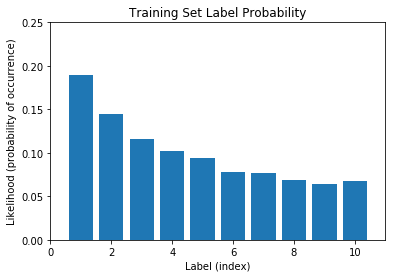

In [21]:
n, bins, patches = plt.hist(training_labels, bins=range(1,12), normed=True, align='left',rwidth=0.8)
plt.axis([0,11,0,0.25])
plt.title("Training Set Label Probability")
plt.ylabel("Likelihood (probability of occurrence)")
plt.xlabel("Label (index)")

Revisiting our narrative from above, if we were to pick a digit at random from our dataset, there's ~20% chance that digit is a `1`, and a ~7.5% chance that digit is a `9`.

This is important to note, since if we see our model is correctly classify classifying 20% of the data, it could be the case that our model is guessing `1` for every classification.
#### Testing Set
Let's also look at this distribution for the testing set, although generally it's a bad idea to peer into the testing set too much prior to training, since knowledge of what the test set looks like invariably influences model-building decisions.

In [22]:
testing_labels = []
for label_group in testing_metadata['label']:
    for label in label_group:
        testing_labels.append(label)

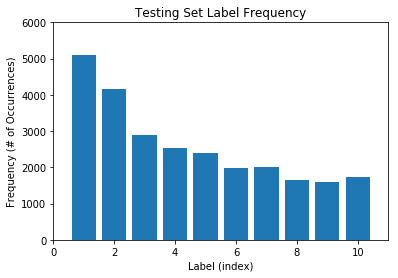

In [23]:
n, bins, patches = plt.hist(testing_labels, bins=range(1,12), align='left',rwidth=0.8)
plt.axis([0,11,0,6000])
plt.title("Testing Set Label Frequency")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("Label (index)")

Note that the scale has been maintained between the training set and the testing set, mostly to convey that there are many more training examples than there are testing examples.  
It appears that the distribution of labels in the testing set is roughly equivalent to the distribution of labels in the training set, but let's plot a probability chart to make that comparison easier.

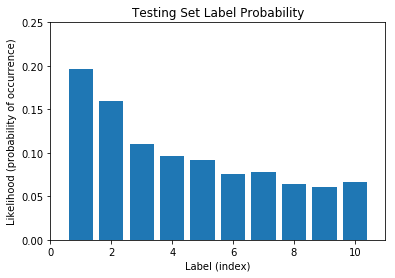

In [24]:
n, bins, patches = plt.hist(testing_labels, bins=range(1,12), normed=True, align='left',rwidth=0.8)
plt.axis([0,11,0,0.25])
plt.title("Testing Set Label Probability")
plt.ylabel("Likelihood (probability of occurrence)")
plt.xlabel("Label (index)")

It would appear, then, that the distributions between the training set and the testing set are comparable.

### Image Cardinality
Just how many digits are we dealing with here anyway?!?!  
That is, what is the distribution of the number of digits per image in the SVHN dataset.

In [25]:
label_count = []
for label_group in training_metadata['label']:
    label_count.append(len(label_group))

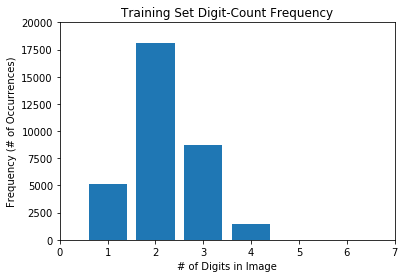

In [26]:
n, bins, patches = plt.hist(label_count, bins = range(1,7), align='left',rwidth=0.8)
plt.axis([0,7,0,20000])
plt.title("Training Set Digit-Count Frequency")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("# of Digits in Image")

In [27]:
label_count.count(0), label_count.count(5), label_count.count(6)

(0, 9, 1)

Note that, in the above histogram, there are no images with `0` digits in them, and there is only one image with `6` digits in it.

It is thus perhaps the case that a Tensor which has been built to identify digits in a given image may be pre-disposed to look for two digits, regardless of whether there are 1 or 6 actually in the image.

# Exploratory Visualization

House numbers aren't always straight.  This is (1) because such precision is hard, and (2) because sometimes sloping numbers look better.

Let's explore how the numbers slope in the SVHN dataset

In [28]:
# Our bin from which to plot a degree histogram
avg_degrees = []

# Consider each image
for i in range(len(training_metadata['left'])):
    
    # Images with only 1 number don't have a defined number slope
    if len(training_metadata['left'][i]) == 1:
        continue
        
    # Our bin from which to average the angle of the numbers
    # This assumes that people _tried_ to put their house numbers on straight
    degreeses = []
    
    # for each coordinate index except the last:
    for j in range(len(training_metadata['left'][i]) - 1):
        
        # Handle zero-division
        if training_metadata['left'][i][j]-training_metadata['left'][i][j+1] == 0:
            # It's assumed that all vertical house numbers descend
            degreeses.append(-90)
        else:
            # Convert slope to degrees, keeping in mind that slope calculation degrades Quadrant information
            tmpDegrees = math.atan((training_metadata['top'][i][j+1]-training_metadata['top'][i][j])/(training_metadata['left'][i][j+1]-training_metadata['left'][i][j]))*180/math.pi
            
            # Add Quadrant information back in
            # i.e. whether a positive line points to Q1 or to Q3, or
            # whether a negative line points to Q4 or Q2
            diff = training_metadata['top'][i][j+1] - training_metadata['top'][i][j]
            
            # A line is positive because it points to Q3
            if diff < 0 and tmpDegrees > 0:
                tmpDegrees -= 180
            
            # A line is negative because it points to Q2
            if diff > 0 and tmpDegrees < 0:
                tmpDegrees += 180
            
            degreeses.append(tmpDegrees)
    
    # Store the average slope for the digits in this image
    avg_degrees.append(np.mean(degreeses))

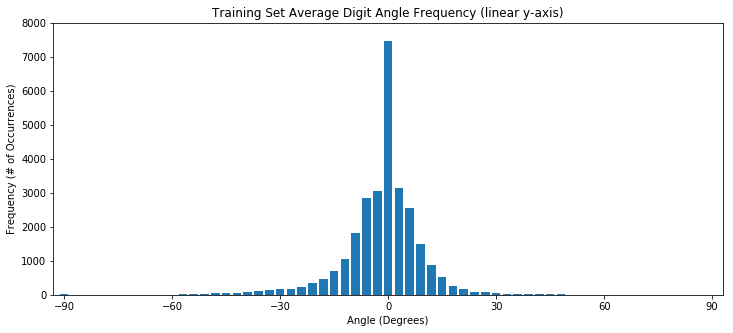

In [29]:
plt.figure(figsize=(12,5))
n, bins, patches = plt.hist(avg_degrees, bins=np.arange(-91.5,93,3), align='mid',rwidth=0.8)
plt.axis([-93,93,0,8000])
plt.xticks([-90, -60, -30, 0, 30, 60, 90])
plt.title("Training Set Average Digit Angle Frequency (linear y-axis)")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("Angle (Degrees)")

In [30]:
def gt_degrees(d):
    gt = 0
    for i in avg_degrees:
        if i > d:
            gt += 1
    return gt

def lt_degrees(d):
    lt = 0
    for i in avg_degrees:
        if i < d:
            lt += 1
    return lt

def bt_degrees(l, h):
    bt = 0
    for i in avg_degrees:
        if l < i < h:
            bt += 1
    return bt

In [31]:
gt_degrees(30), gt_degrees(60), gt_degrees(75), gt_degrees(90)

(165, 16, 9, 2)

In [32]:
bt_degrees(90, 93), bt_degrees(173,175)

(1, 1)

In [33]:
lt_degrees(-30), lt_degrees(-60), lt_degrees(-75), lt_degrees(-90), 

(685, 33, 25, 0)

In [34]:
bt_degrees(-91.5, -88.5)

12

Interestingly, as can be seen above, there are 9 images in which the slope of the numbers suggests a bottom-to-top ordering.  This almost certainly wasn't intentional.

Is this an error in the dataset?  If so, it affects only a few of the images.

Note also that there aren't any images in which the house numbers are angled beyond -90 degrees.  This suggests that no one placed numbers close enough to bottom-to-top orientation for the error inherent in placing numbers to cause that particular placement to exceed -90 degrees.  Neat!

Let's view the same plot, but with a logarithmically-scaled y-axis, to better see the above-identified outliers.

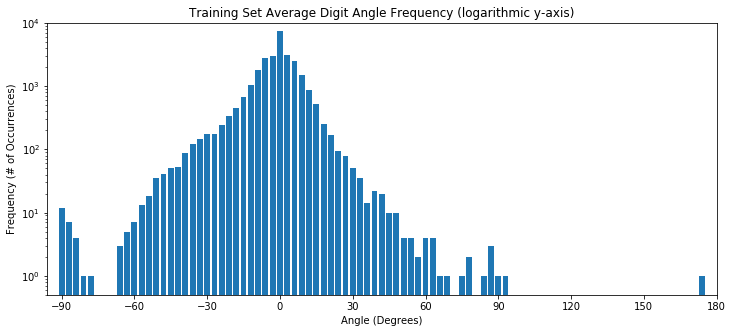

In [35]:
plt.figure(1, figsize=(12,5))
plt.yscale('log')
plt.ylim(0.5, 10000)
plt.xlim(-96, 180)
n, bins, patches = plt.hist(avg_degrees, bins=np.arange(-91.5, 180, 3), align='mid',rwidth=0.8)
plt.xticks([-90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
plt.title("Training Set Average Digit Angle Frequency (logarithmic y-axis)")
plt.ylabel("Frequency (# of Occurrences)")
plt.xlabel("Angle (Degrees)")

As we can see in the above histograms, house numbers are predominately flattish, but some slope upwards (have a positive `Angle`), and some slope downwards (have a negative `Angle`).

As expected, the tail on the negative side is fatter than on the positive side, meaning that more house numbers slope downwards than slope upwards.

This makes sense, as bottom-to-top ordering is not the reading convention anywhere.
![Writing Directions of the World](images/Writing_directions_of_the_world.svg)
(image [source](https://en.wikipedia.org/wiki/Writing_system#/media/File:Writing_directions_of_the_world.svg))  

### Relevance to Analysis
This suggests that the house numbers are, by overwhelming majority, ordered left-to-right.  Thus, after having identified digits in the SVHN images, digits can be ordered in the output based off of their `x-coordinate`, or `training_metadata['left']` value as referred to above.

# Algorithms and Techniques
## Image Preprocessing
The images in the SVHN dataset are many different sizes:
```
$ file *.png
...
28668.png:             PNG image data, 153 x 73, 8-bit/color RGB, non-interlaced
28669.png:             PNG image data, 67 x 34, 8-bit/color RGB, non-interlaced
2866.png:              PNG image data, 44 x 21, 8-bit/color RGB, non-interlaced
28670.png:             PNG image data, 100 x 50, 8-bit/color RGB, non-interlaced
28671.png:             PNG image data, 83 x 34, 8-bit/color RGB, non-interlaced
28672.png:             PNG image data, 108 x 49, 8-bit/color RGB, non-interlaced
...
```
Unfortunately, our neural net will need its input to be consistently-sized.  
That is to say, we need to pick *a* size to which we resize all images, before we feed them to the neural net.

Images which are larger than the destination size are going to *lose* some information, while images which are the destination size or smaller aren't going to gain information.  
Accordingly, we want to pick a size where information loss isn't significant.

A note here:  
Just because we downsize the image doesn't mean that there is significant information loss.  
A 3200x4800 image of the letter `A` is probably still faithfully represented if downsized to 32x48, or smaller.

Let's get an idea of the input dimensions:

In [36]:
training_img_width, training_img_height = [], []

for f in training_filenames:
    with Image.open(training_directory + f) as im:
        w, h = im.size
        
        training_img_width.append(w)
        training_img_height.append(h)

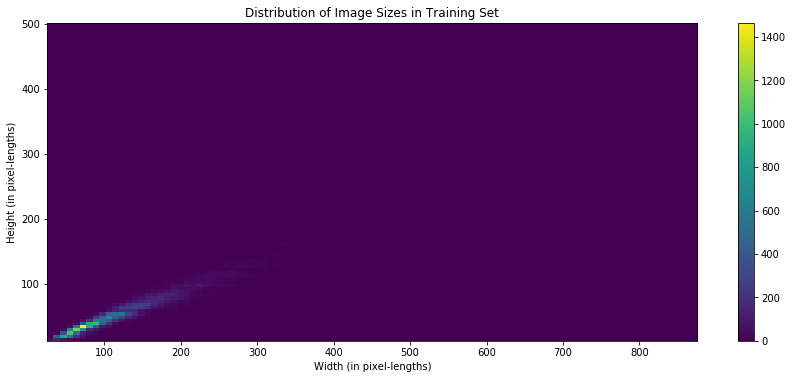

In [37]:
plt.figure(1, figsize=(12,5))
plt.hist2d(training_img_width, training_img_height, bins=100)
plt.tight_layout()
plt.colorbar()
plt.title("Distribution of Image Sizes in Training Set")
plt.xlabel("Width (in pixel-lengths)")
plt.ylabel("Height (in pixel-lengths)")
plt.show()

In [38]:
testing_img_width, testing_img_height = [], []

for f in testing_filenames:
    with Image.open(testing_directory + f) as im:
        w, h = im.size
        
        testing_img_width.append(w)
        testing_img_height.append(h)

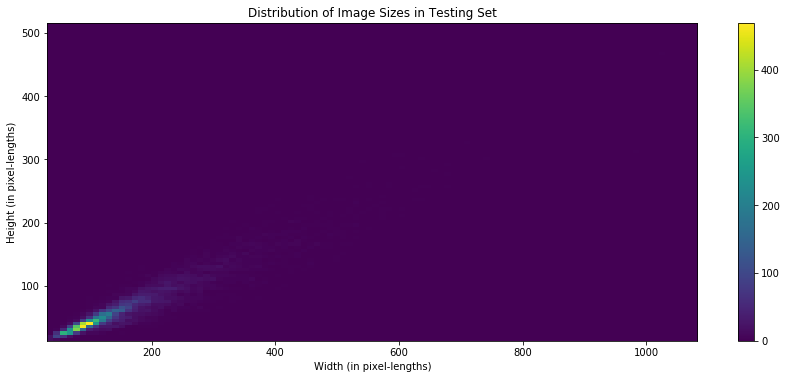

In [39]:
plt.figure(1, figsize=(12,5))
plt.hist2d(testing_img_width, testing_img_height, bins=100)
plt.tight_layout()
plt.colorbar()
plt.title("Distribution of Image Sizes in Testing Set")
plt.xlabel("Width (in pixel-lengths)")
plt.ylabel("Height (in pixel-lengths)")
plt.show()

Notice that the above plot suggests that the vast majority of the images are less than 50-or-so pixels tall, and many of them are less than 100 pixels wide.

That is, we can probably downsize these images to 64 x 64 and (hopefully) not lose a lot of information.

In [40]:
training_img_pixels = []
for i in range(len(training_img_width)):
    training_img_pixels.append(training_img_width[i] * training_img_height[i])

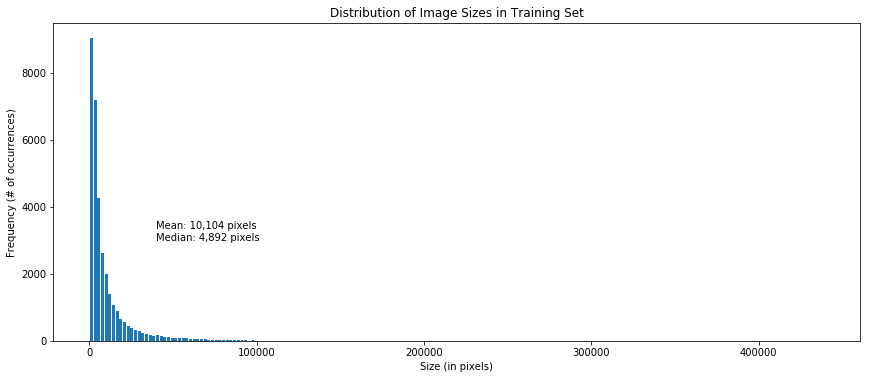

In [41]:
plt.figure(1, figsize=(12,5))
plt.hist(training_img_pixels, bins=200, rwidth=0.8)
plt.tight_layout()
txt = "Mean: {:,.0f} pixels".format(np.mean(training_img_pixels))
txt += "\nMedian: {:,.0f} pixels".format(np.median(training_img_pixels))
plt.text(40000, 3000, txt)
plt.title("Distribution of Image Sizes in Training Set")
plt.xlabel("Size (in pixels)")
plt.ylabel("Frequency (# of occurrences)")
plt.show()

In [42]:
testing_img_pixels = []
for i in range(len(testing_img_width)):
    testing_img_pixels.append(testing_img_width[i] * testing_img_height[i])

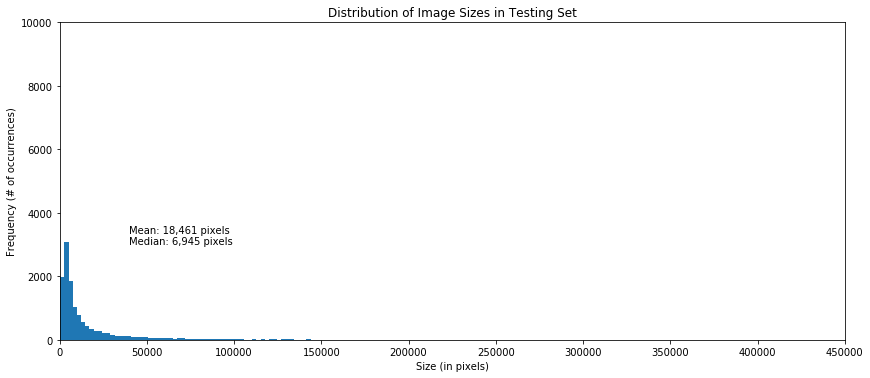

In [43]:
plt.figure(1, figsize=(12,5))
plt.hist(testing_img_pixels, bins=200)
plt.axis([0,450000,0,10000])
plt.tight_layout()
txt = "Mean: {:,.0f} pixels".format(np.mean(testing_img_pixels))
txt += "\nMedian: {:,.0f} pixels".format(np.median(testing_img_pixels))
plt.text(40000, 3000, txt)
plt.title("Distribution of Image Sizes in Testing Set")
plt.xlabel("Size (in pixels)")
plt.ylabel("Frequency (# of occurrences)")
plt.show()

Let's arbitrarily go with ~~128x128~~ 64x64, the size used by Goodfellow et al. for the ~~internal~~ public dataset.  
But hold on, we can't just rescale our input images, or we'd get too-squished input like this:

In [44]:
import os
import cv2
import h5py
import math
import numpy as np
from PIL import Image
from scipy import misc
import random as rand
from operator import add
from six.moves import cPickle as pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches

training_directory = "train/"
training_filenames = []
# Note that training_filenames is 0-indexed, but that there is no 0.png
# so, x.png = training_filenames[x-1]
for i in range(1, 33403):
    training_filenames.append(str(i)+'.png')

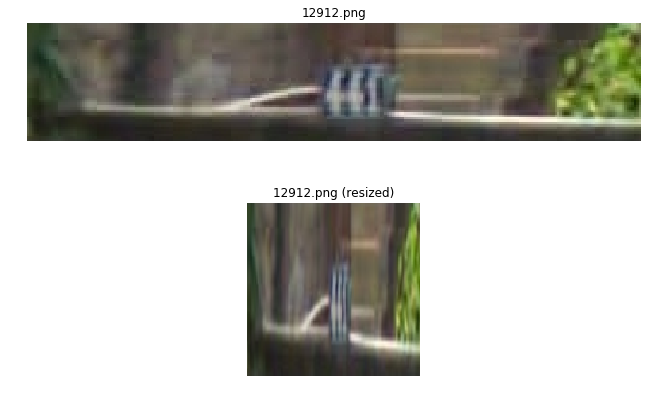

In [45]:
fig = plt.figure(figsize=(11, 7))
i = 12912
#with open(training_directory + training_filenames[i-1]) as f:
f = training_directory + str(i) + ".png"
fig.add_subplot(211)
plt.axis("off")
plt.title(str(i) + ".png")
img = mpimg.imread(f)
plt.imshow(img)
    
fig.add_subplot(212)
plt.axis("off")
img = misc.imresize(img, (128,128))
plt.title(str(i) + ".png (resized)")
plt.imshow(img)
plt.show()

We need to be more clever about how we downsize.
## Clever Image Preprocessing
[Goodfellow et al.](https://arxiv.org/pdf/1312.6082v4.pdf) describe the following steps to their image preprocessing:
1. **Find the rectangular bounding box** that will contain individual character bounding boxes.  
   Note that this means finding `y_min`, `y_max`, `x_min`, and `x_max` such that, for each image, no bounding box is clipped.  
   Note further that, for each individual character bounding box, `x_min` is simply `training_metadata['left'][i]`, and `y_min` is `training_metadata['top'][i]` (the y-axis is positive in the downward direction).  
   Then, `y_max` can be found by adding `training_metadata['height'][i]` to `y_min`, and `x_max` can be found by adding `training_metadata['width'][i]` to `x_min`.  
   Then, we simply take the lowest of the `x_min` and `y_min`, and the largest of the `x_max` and `y_max`.

2. **Expand the rectangular bounding box** by 30% in the `x` and `y` directions.  
   This seems like they are intending to increase from the rectangle's centroid, so that if we have a `width` of 20, then `x_min` decreases by 3, and `x_max` increases by 3.
   
3.  **Crop the image** to this bounding box.  
   Note that, if the expanded bounding box extends beyond the image dimensions, the box will have to be cropped to fit the image.

4.  **Resize the image** to 64 x 64.  
   This step can make use of the pipeline we defined earlier, now that we have a better idea, for each image, where the pixels containing the digit information are located.
   
5.  **Crop several 54 x 54 images** from random locations within the 64 x 64 image.
   This step increases the size of the dataset, which is good for training purposes.
   Note that this step **may** cause us to lose some digit information:  
   1. For each image, we've defined a **rectangle** which bounds all digit boxes.  Therefore the digits are probably in that rectangle.  
   2. Then, we upsized the box by 30%, which is a 15% increase on each axis, on each side.  
   3. Then we resize, which decreases resolution, but doesn't change the relative location of boundaries.  
   4. *Then*, we crop from to 54 pixels from 64 pixels.  
   Since we would have to multiply 54 by 18.52% to get back to 64, if the pixels were all cropped from one side (as might happen due to randomness), then we may sometimes crop **inside** of the original digit-containing rectangle, and maybe even cut into some digits.  
   
   This is probably not a huge deal, but it's worth noting.
   
6. **Subtract the mean** of each image

Let's implement this preprocessing pipeline:
### Find the Rectangular Bounding Box

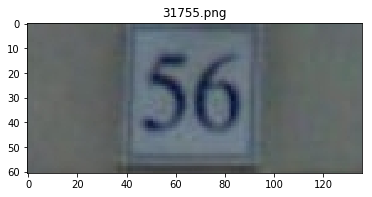

In [46]:
i = 31755
#with open(training_directory + training_filenames[i - 1]) as f:
f = training_directory + str(i) +  ".png"   
#plt.axis("off")
plt.title(str(i) + ".png")
img = mpimg.imread(f)
plt.imshow(img)

In [47]:
training_metadata['label'][i - 1]

[5.0, 6.0]

In [48]:
x_min = min(training_metadata['left'][i-1])
y_min = min(training_metadata['top'][i-1])
x_min, y_min

(41.0, 1.0)

In [49]:
max(map(add, training_metadata['left'][i-1], training_metadata['width'][i-1]))

89.0

In [50]:
x_max = max(map(add, training_metadata['left'][i-1], training_metadata['width'][i-1]))
y_max = max(map(add, training_metadata['top'][i-1], training_metadata['height'][i-1]))
x_max, y_max

(89.0, 50.0)

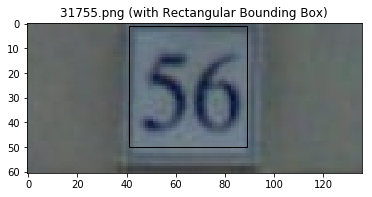

In [51]:
fig, ax = plt.subplots(1)
#with open(training_directory + training_filenames[i - 1]) as f:
f = training_directory + str(i) + ".png"
bbox = matplotlib.patches.Rectangle((x_min, y_min),
    x_max - x_min,
    y_max - y_min,
    fill=False)      # remove background
ax.add_patch(bbox)
plt.title(str(i) + ".png (with Rectangular Bounding Box)")
img = mpimg.imread(f)
plt.imshow(img)

#fig.show()

Let's define a helper function for retrieving the bounding box:

In [52]:
def getBBox(i, train=True):
    '''
    Given i, the desired i.png, returns
    x_min, y_min, x_max, y_max,
    the four numbers which define the small rectangular bounding
    box that contains all individual character bounding boxes
    '''
    if train:
        metadata = training_metadata
    else:
        metadata = testing_metadata
    
    x_min = min(metadata['left'][i-1])
    y_min = min(metadata['top'][i-1])
    x_max = max(map(add, metadata['left'][i-1], metadata['width'][i-1]))
    y_max = max(map(add, metadata['top'][i-1], metadata['height'][i-1]))
    return x_min, y_min, x_max, y_max

In [53]:
training_metadata.keys()
training_metadata['left'][31750-1]
#training_metadata['top'][31750-1]
#training_metadata['label'][31750-1]

[191.0, 213.0, 230.0]

In [54]:
print(getBBox(i))

(41.0, 1.0, 89.0, 50.0)


### Expand the Rectangular Bounding Box
Here, given a bounding box, we want to expand the box by 30% in the x and y directions, spread evenly from the centroid.

In [55]:
x_min, y_min, x_max, y_max = getBBox(i)

In [56]:
x_d = x_max - x_min
y_d = y_max - y_min
x_d, y_d

(48.0, 49.0)

In [57]:
x_min -= (0.3 * x_d) // 2
x_max += (0.3 * x_d) // 2
y_min -= (0.3 * y_d) // 2
y_max += (0.3 * y_d) // 2
x_min, y_min, x_max, y_max

(34.0, -6.0, 96.0, 57.0)

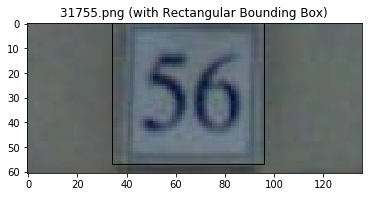

In [58]:
fig, ax = plt.subplots(1)
#with open(training_directory + training_filenames[i - 1]) as f:
f = training_directory + str(i) + ".png"
bbox = matplotlib.patches.Rectangle((x_min, y_min),
    x_max - x_min,
    y_max - y_min,
    fill=False)      # remove background
ax.add_patch(bbox)
plt.title(str(i) + ".png (with Rectangular Bounding Box)")
img = mpimg.imread(f)
plt.imshow(img)

#fig.show()

Let's define a helper function for expanding the bounding box by 30%

In [59]:
def expandBBox(x_min, y_min, x_max, y_max):
    '''
    Given the four boundaries of the bounding box, returns
    those boundaries expanded out from the centroid by 30%, as
    x_min, y_min, x_max, y_max
    '''
    # The delta will be 30% of the width or height, (integer) halved
    x_d = ((x_max - x_min) * 0.3) // 2
    y_d = ((y_max - y_min) * 0.3) // 2
    return x_min - x_d, y_min - y_d, x_max + x_d, y_max + y_d

In [60]:
print(expandBBox(*getBBox(i)))

(34.0, -6.0, 96.0, 57.0)


### Crop the Image
Now that we have our bounding box, we need to crop the given image to fit inside that box.  
Recall that we also need to handle situations where the bounding box is outside the dimensions of the image.  
In these situations, we will simply crop the part of the bounding box that extends outside of the image.

First, let's get our crop function working on an image whose expanded bounded box is *inside* the original image.

181.0 6.0 269.0 96.0


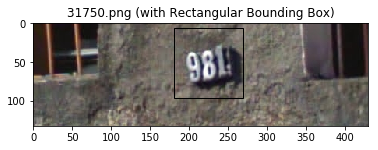

In [61]:
i = 31750
fig, ax = plt.subplots(1)
#with open(training_directory + training_filenames[i - 1]) as f:
f = training_directory + str(i) + ".png"
x_min, y_min, x_max, y_max = expandBBox(*getBBox(i))
bbox = matplotlib.patches.Rectangle((x_min, y_min),
    x_max - x_min,
    y_max - y_min,
    fill=False)      # remove background
ax.add_patch(bbox)
plt.title(str(i) + ".png (with Rectangular Bounding Box)")
img = mpimg.imread(f)
plt.imshow(img)
print(x_min, y_min, x_max, y_max)

#fig.show()

181.0 6.0 269.0 96.0


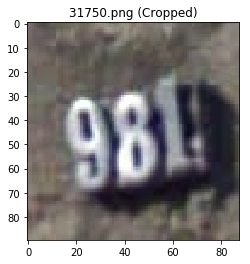

In [62]:
fig, ax = plt.subplots(1)
#with open(training_directory + training_filenames[i - 1]) as f:
x_min, y_min, x_max, y_max = expandBBox(*getBBox(i))
bbox = matplotlib.patches.Rectangle((x_min, y_min),
    x_max - x_min,
    y_max - y_min,
    fill=False)      # remove background
ax.add_patch(bbox)
plt.title(str(i) + ".png (Cropped)")
img = mpimg.imread(f)
# Slice into the Image to crop it
plt.imshow(img[int(y_min):int(y_max), int(x_min):int(x_max)])
print(x_min, y_min, x_max, y_max)

#fig.show()

Next, let's get our crop function working on an image whose expanded bounded box is *outside* the original image.

22.0 -3.0 40.0 33.0


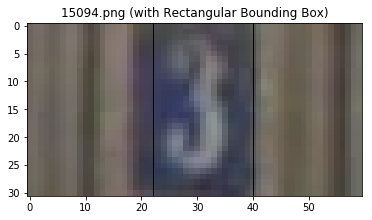

In [63]:
i = 15094
fig, ax = plt.subplots(1)
##with open(training_directory + training_filenames[i - 1]) as f:
f = training_directory + (str(i)) + ".png"
x_min, y_min, x_max, y_max = expandBBox(*getBBox(i))
bbox = matplotlib.patches.Rectangle((x_min, y_min),
    x_max - x_min,
    y_max - y_min,
    fill=False)      # remove background
ax.add_patch(bbox)
plt.title(str(i) + ".png (with Rectangular Bounding Box)")
img = mpimg.imread(f)
plt.imshow(img)
print(x_min, y_min, x_max, y_max)

#fig.show()

22.0 0 40.0 31


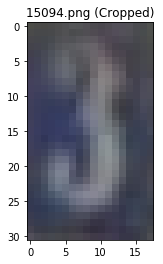

In [64]:
fig, ax = plt.subplots(1)
#with open(training_directory + training_filenames[i - 1]) as f:
x_min, y_min, x_max, y_max = expandBBox(*getBBox(i))
    
# crop our bounding box to fit within the given image
if x_min < 0: x_min = 0
if y_min < 0: y_min = 0
x_max = min(x_max, 60) # img.shape[1]
y_max = min(y_max, 31) # img.shape[0]
    
bbox = matplotlib.patches.Rectangle((x_min, y_min),
    x_max - x_min,
    y_max - y_min,
    fill=False)      # remove background
ax.add_patch(bbox)
plt.title(str(i) + ".png (Cropped)")
img = mpimg.imread(f)
plt.imshow(img[int(y_min):int(y_max), int(x_min):int(x_max)])
print(x_min, y_min, x_max, y_max)

#fig.show()

Let's define a helper function to crop the the bounding box for a given image

In [65]:
def cropBBox(img, x_min, y_min, x_max, y_max):
    '''
    Given a numpy array representing an image, and
    the four boundaries of the bounding box, returns
    the cropped bounding box, as
    x_min, y_min, x_max, y_max
    '''
    x_min = max(0, int(x_min))
    y_min = max(0, int(y_min))
    x_max = min(int(img.shape[1]), int(x_max))
    y_max = min(int(img.shape[0]), int(y_max))
    return int(x_min), int(y_min), int(x_max), int(y_max)

22 0 40 31


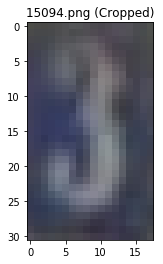

In [66]:
fig, ax = plt.subplots(1)
#with open(training_directory + training_filenames[i - 1]) as f:
img = mpimg.imread(f)
x_min, y_min, x_max, y_max = cropBBox(img, *expandBBox(*getBBox(i)))
    
bbox = matplotlib.patches.Rectangle((x_min, y_min),
    x_max - x_min,
    y_max - y_min,
    fill=False)      # remove background
ax.add_patch(bbox)
plt.title(str(i) + ".png (Cropped)")
plt.imshow(img[y_min:y_max, x_min:x_max])
print(x_min, y_min, x_max, y_max)

#fig.show()

### Resize the Image
We've already hinted at how to resize images above, but let's formalize that process by defining a helper function

In [67]:
import os
import cv2
import h5py
import math
import numpy as np
from PIL import Image
from scipy import misc
import random as rand
from operator import add
from six.moves import cPickle as pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches
%matplotlib inline

In [68]:
def getResized(f,train=True):
    '''
    Given an open file f, representing the desired image file,
    and a boolean representing whether this is a training image
    or a testing image,
    returns a numpy array, which is the portion of the
    image enclosed by the bounding box around all digits,
    resized to:
    64 pixels by 64 pixels if train=True,
    54 pixels by 54 pixels if train=False
    '''
    # Read the file as a numpy array
    img = mpimg.imread(f.name)
    #img = mpimg.imread("train/1.png")
    
    # Get the index i from our filename
    if train:
        i = int(f.name[6:].split('.')[0])
        #i = int(f.name.split('.')[0])

    else:
        i = int(f.name[5:].split('.')[0])
        #i = int(f.name.split('.')[0])

    # Get our final expanded, cropped digit-bounding box
    x_min, y_min, x_max, y_max = cropBBox(img, *expandBBox(*getBBox(i, train)))
    
    # Return the cropped, resized numpy array
    if train:
        return misc.imresize(img[y_min:y_max, x_min:x_max], (64,64))
        #return img
    else:
        return misc.imresize(img[y_min:y_max, x_min:x_max], (54,54))
        


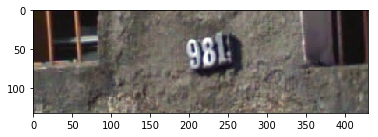

In [69]:
i = 31750
file_name = training_directory + str(i) + '.png'
img = plt.imread(file_name)
plt.imshow(img)

train/31750.png


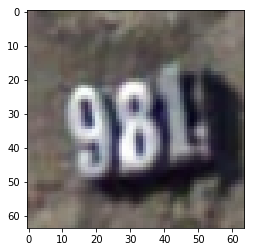

In [70]:
i = 31750
file_name = training_directory + str(i) + '.png'
img = plt.imread(file_name)
plt.imshow(img)
with open(file_name,'r') as f:
    print (f.name)
    plt.imshow(getResized(f))
f.close()

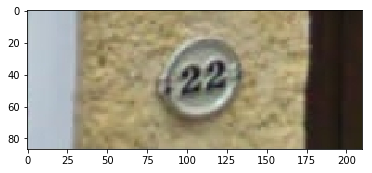

In [71]:
i = 5555
file_name = testing_directory + str(i) + '.png'
img = plt.imread(file_name)
plt.imshow(img)

test/5555.png


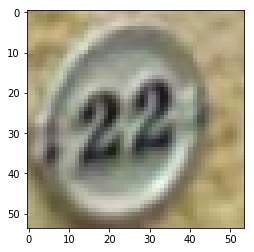

In [72]:
i = 5555
file_name = testing_directory + str(i) + '.png'
img = plt.imread(file_name)
plt.imshow(img)
with open(file_name,'r') as f:
    print (f.name)
    plt.imshow(getResized(f,train=False))
f.close()

### Crop Several Smaller Images
Exactly how many smaller images we'll want is unclear (3? 5? 10?), so let's define a function that randomly returns *a single* 54 x 54 cropped image from a given 64 x 64 image.  
That way, later we can tweak how many times we call that function.

In [73]:
i = 31750
f = open(training_directory + str(i) + '.png')
img = getResized(f)
f.close()

In [74]:
def getRandomSmaller(img):
    '''
    Given img, a 64 x 64 numpy array representing an image,
    returns a randomly-sliced 54 x 54 numpy array,
    representing a crop of the original image
    '''
    x_min = rand.randint(0,10)
    x_max = 64 - (10 - x_min)
    y_min = rand.randint(0,10)
    y_max = 64 - (10 - y_min)
    return img[y_min:y_max, x_min:x_max]

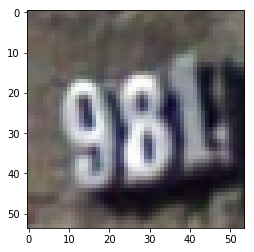

In [75]:
plt.imshow(getRandomSmaller(img))

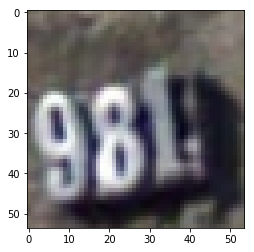

In [76]:
plt.imshow(getRandomSmaller(img))

### Subtract the mean of each image
Recall that the images are stored as numpy arrays.  
Thus, we can compute the mean of the numpy array, then subtract the mean from each index of the array.  
Note that, after having done this, we will have negative values in the numpy array.  
Thus, while the numpy array will still represent an image, it can't be displayed as an image without first handling the negatives in some way.

In [77]:
img

array([[[121, 109, 104],
        [114, 103, 101],
        [ 99,  88,  86],
        ..., 
        [130, 120, 117],
        [131, 120, 117],
        [137, 126, 123]],

       [[119, 106, 103],
        [111, 100,  99],
        [ 99,  88,  89],
        ..., 
        [136, 127, 121],
        [136, 126, 119],
        [139, 129, 122]],

       [[117, 104, 103],
        [109,  97,  97],
        [102,  91,  92],
        ..., 
        [135, 127, 117],
        [134, 124, 115],
        [137, 128, 117]],

       ..., 
       [[126, 117, 108],
        [130, 122, 112],
        [139, 133, 120],
        ..., 
        [124, 115, 105],
        [124, 115, 106],
        [130, 122, 112]],

       [[135, 126, 116],
        [137, 132, 120],
        [142, 139, 123],
        ..., 
        [115, 107,  97],
        [116, 107,  98],
        [120, 114, 103]],

       [[139, 132, 120],
        [141, 136, 123],
        [142, 139, 123],
        ..., 
        [112, 104,  93],
        [114, 108,  97],
        [118, 113,

In [78]:
np.mean(img)

98.638916015625

In [79]:
def subtractMean(img):
    '''
    Given img, a numpy array representing an image,
    subtracts the mean from the numpy array and returns
    the mean-subtracted result
    '''
    return img - np.mean(img)

In [80]:
subtractMean(img)

array([[[ 22.36108398,  10.36108398,   5.36108398],
        [ 15.36108398,   4.36108398,   2.36108398],
        [  0.36108398, -10.63891602, -12.63891602],
        ..., 
        [ 31.36108398,  21.36108398,  18.36108398],
        [ 32.36108398,  21.36108398,  18.36108398],
        [ 38.36108398,  27.36108398,  24.36108398]],

       [[ 20.36108398,   7.36108398,   4.36108398],
        [ 12.36108398,   1.36108398,   0.36108398],
        [  0.36108398, -10.63891602,  -9.63891602],
        ..., 
        [ 37.36108398,  28.36108398,  22.36108398],
        [ 37.36108398,  27.36108398,  20.36108398],
        [ 40.36108398,  30.36108398,  23.36108398]],

       [[ 18.36108398,   5.36108398,   4.36108398],
        [ 10.36108398,  -1.63891602,  -1.63891602],
        [  3.36108398,  -7.63891602,  -6.63891602],
        ..., 
        [ 36.36108398,  28.36108398,  18.36108398],
        [ 35.36108398,  25.36108398,  16.36108398],
        [ 38.36108398,  29.36108398,  18.36108398]],

       ..., 
   

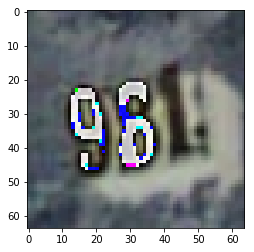

In [81]:
# Note that Matplotlib is unable to display the mean-subtracted
# numpy array without distortion
plt.imshow(subtractMean(img))

## The Training Data
### Creating and Saving  
Now that we've defined a pipeline for generating training data, let's create some.

In [82]:
def createAndSaveData(train=True, num_random_subsamples=5):
    '''
    Given a boolean representing whether "train" or not (i.e. "test"),
    returns an array of smaller, randomly-jittered, mean-subtracted images.
    
    That array can then be saved to a numpy array file, and reloaded when needed,
    rather than having to preprocess the data again.
    '''
    im_array = []
    fn = "54x54.npy"
    fn_tenth = "54x54tenth.npy"
    
    if train:
        directory = "train/"
        #dir_fd = os.open(directory, os.O_RDONLY)
        filenames = training_filenames
    else:
        directory = "test/"
        #dir_fd = os.open(directory, os.O_RDONLY)
        filenames = testing_filenames
    
    #def opener(path, flags):
    #    return os.open(path, flags, dir_fd=dir_fd)

    for i in filenames:
        with open(directory + i) as f:
            img = getResized(f, train)
            f.close()
            if train:
                for j in range(num_random_subsamples):
                    im_array.append(subtractMean(getRandomSmaller(img)))
            else:
                im_array.append(subtractMean(img))
    np.save(directory + fn, im_array)
    np.save(directory + fn_tenth, im_array[:len(im_array)//10])

In [83]:
createAndSaveData(train=True)

MemoryError: 

In [106]:
createAndSaveData(train=False)

NameError: name 'dir_fd' is not defined

Now, we need to generate labels that match the training data that we just created.

This should consist of [Length, d1(, d2, d3, d4, d5)]

In [ ]:
def saveLabels(train=True, num_random_subsamples=5):
    
    if train:
        directory = training_directory
        metadata = training_metadata
        l = train_l
    else:
        directory = testing_directory
        metadata = testing_metadata
        l = test_l
    
    # where r stands for "randomCroppedLabels"
    r0 = []
    r1 = []
    r2 = []
    r3 = []
    r4 = []
    r5 = []
    for i in range(0, l):
        a = metadata['label'][i]
        label = [len(a)]
        for n in a:
            label.append(n)
        while len(label) < 6:
            label.append(10)
        if train:
            for j in range(num_random_subsamples):
                r0.append(label[0])
                r1.append(label[1])
                r2.append(label[2])
                r3.append(label[3])
                r4.append(label[4])
                r5.append(label[5])
        else:
            r0.append(label[0])
            r1.append(label[1])
            r2.append(label[2])
            r3.append(label[3])
            r4.append(label[4])
            r5.append(label[5])
    
    for i, r in enumerate([r0,r1,r2,r3,r4,r5]):
        np.save(directory + 'labels' + str(i) + '.npy', r)
        np.save(directory + 'labels' + str(i) + 'tenth.npy', r[:len(r)//10])

In [ ]:
saveLabels(train=True)

In [ ]:
saveLabels(train=False)

### Loading the Training Data 
Finally, we'll want to create some calls for loading the training data we just created.

#### Loading the Full Dataset

In [ ]:
X_train = np.load('data/train/54x54.npy')

In [ ]:
y0_train = np.load('data/train/labels0.npy')
y1_train = np.load('data/train/labels1.npy')
y2_train = np.load('data/train/labels2.npy')
y3_train = np.load('data/train/labels3.npy')
y4_train = np.load('data/train/labels4.npy')
y5_train = np.load('data/train/labels5.npy')

In [ ]:
y0_train[0], y1_train[0], y2_train[0], y3_train[0], y4_train[0], y5_train[0]

In [ ]:
X_test = np.load('data/test/54x54.npy')

In [ ]:
y0_test = np.load('data/test/labels0.npy')
y1_test = np.load('data/test/labels1.npy')
y2_test = np.load('data/test/labels2.npy')
y3_test = np.load('data/test/labels3.npy')
y4_test = np.load('data/test/labels4.npy')
y5_test = np.load('data/test/labels5.npy')

#### Loading a Tenth of the Dataset

In [ ]:
test_size = 0.33
cut = int(((train_l * num_random_subsamples) // 10) * test_size)

In [ ]:
X_train = np.load('data/train/54x54tenth.npy')

In [ ]:
y0_train = np.load('data/train/labels0tenth.npy')
y1_train = np.load('data/train/labels1tenth.npy')
y2_train = np.load('data/train/labels2tenth.npy')
y3_train = np.load('data/train/labels3tenth.npy')
y4_train = np.load('data/train/labels4tenth.npy')
y5_train = np.load('data/train/labels5tenth.npy')

In [ ]:
y0_train[0], y1_train[0], y2_train[0], y3_train[0], y4_train[0], y5_train[0]

### Loading the Testing Data

## The Neural Net
We will be building a neural net to output the digits from input images.  The architecture will try to follow, as closely as possible, that architecture described by Goodfellow et al., below:
>Our best architecture consists of eight convolutional hidden layers, one locally connected hidden layer, and two densely connected hidden layers. All connections are feedforward and go from one layer to the next (no skip connections).  
>
The first hidden layer contains maxout units (Goodfellow et al., 2013) (with three filters per unit) while the others contain rectifier units (Jarrett et al., 2009; Glorot et al., 2011).  
> 
The number of units at each spatial location in each layer is [48, 64, 128, 160] for the first four layers and 192 for all other locally connected layers. The fully connected layers contain 3,072 units each.  
>
Each convolutional layer includes max pooling and subtractive normalization. The max pooling window size is 2 × 2. The stride alternates between 2 and 1 at each layer, so that half of the layers don’t reduce the spatial size of the representation.  
>
All convolutions use zero padding on the input to preserve representation size. The subtractive normalization operates on 3x3 windows and preserves representation size.  
>
All convolution kernels were of size 5 × 5. We trained with dropout applied to all hidden layers but not the input.

Below is a sketch of the model architecture that best comports with this description:
```
(0) input (54 x 54 x 3 image)
(1) same-pad 5 × 5 conv  [48] -> 2 × 2 max pooling (stride 2) -> 3 × 3 subtractive normalization -> dropout -> 3-filter maxout
(2) same-pad 5 × 5 conv  [64] -> 2 × 2 max pooling (stride 1) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(3) same-pad 5 × 5 conv [128] -> 2 × 2 max pooling (stride 2) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(4) same-pad 5 × 5 conv [160] -> 2 × 2 max pooling (stride 1) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(5) same-pad 5 × 5 conv [192] -> 2 × 2 max pooling (stride 2) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(6) same-pad 5 × 5 conv [192] -> 2 × 2 max pooling (stride 1) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(7) same-pad 5 × 5 conv [192] -> 2 × 2 max pooling (stride 2) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(8) same-pad 5 × 5 conv [192] -> 2 × 2 max pooling (stride 1) -> 3 × 3 subtractive normalization -> dropout -> ReLU
(9) flatten
(10) fully-connected [3072] -> dropout
(11) fully-connected [3072] -> dropout
(12) output
```
Note that the output itself is relatively complex (see image below), and will be dealt with in more detail after the hidden layers.
![Goodfellow et al. Neural Net Architecture](images/architecture.png)  
Note that the 128 x 128 x 3 referred to above is for the image processing pipeline for the *private* SVHN dataset, to which only Google has access.  
For the *public* SVHN dataset, that portion of the above graphic should read 54 x 54 x 3, in accordance with the preprocessing pipeline which Goodfellow et al. define in their section 5.1, which this notebook attempts to recreate.  

This model architecture will be implemented in TensorFlow, using Keras as a front-end to aid in layer construction and management.

In [ ]:
from keras.callbacks import TensorBoard
from keras.layers import Input, Convolution2D, MaxPooling2D, Dropout, Flatten, MaxoutDense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Dense
from keras.models import Model

In [ ]:
img_channels = 3
img_rows = 54
img_cols = 54

In [ ]:
# Layer 0: Input
x = Input((img_rows, img_cols, img_channels))

# Layer 1: 48-unit maxout convolution
y = Convolution2D(nb_filter = 48, nb_row = 5, nb_col = 5, border_mode="same", name="1conv")(x)
y = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), border_mode="same", name="1maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="1drop")(y)
# y = MaxoutDense(output_dim = 48, nb_feature=3)(y)
y = Activation('relu', name="1activ")(y)

# Layer 2: 64-unit relu convolution
y = Convolution2D(nb_filter = 64, nb_row = 5, nb_col = 5, border_mode="same", name="2conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), border_mode="same", name="2maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="2drop")(y)
y = Activation('relu', name="2activ")(y)

# Layer 3: 128-unit relu convolution
y = Convolution2D(nb_filter = 128, nb_row = 5, nb_col = 5, border_mode="same", name="3conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), border_mode="same", name="3maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="3drop")(y)
y = Activation('relu', name="3activ")(y)

# Layer 4: 160-unit relu convolution
y = Convolution2D(nb_filter = 160, nb_row = 5, nb_col = 5, border_mode="same", name="4conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), border_mode="same", name="4maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="4drop")(y)
y = Activation('relu', name="4activ")(y)

# Layer 5: 192-unit relu convolution
y = Convolution2D(nb_filter = 192, nb_row = 5, nb_col = 5, border_mode="same", name="5conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), border_mode="same", name="5maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="5drop")(y)
y = Activation('relu', name="5activ")(y)

# Layer 6: 192-unit relu convolution
y = Convolution2D(nb_filter = 192, nb_row = 5, nb_col = 5, border_mode="same", name="6conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), border_mode="same", name="6maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="6drop")(y)
y = Activation('relu', name="6activ")(y)

# Layer 7: 192-unit relu convolution
y = Convolution2D(nb_filter = 192, nb_row = 5, nb_col = 5, border_mode="same", name="7conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), border_mode="same", name="7maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="7drop")(y)
y = Activation('relu', name="7activ")(y)

# Layer 8: 192-unit relu convolution
y = Convolution2D(nb_filter = 192, nb_row = 5, nb_col = 5, border_mode="same", name="8conv")(y)
y = MaxPooling2D(pool_size = (2, 2), strides = (1, 1), border_mode="same", name="8maxpool")(y)
# y = SubtractiveNormalization((3,3))(y)
y = Dropout(0.25, name="8drop")(y)
y = Activation('relu', name="8activ")(y)

# Layer 9: Flatten
y = Flatten()(y)

# Layer 10: Fully-Connected Layer
y = Dense(3072, activation=None, name="fc1")(y)

# Layer 11: Fully-Connected Layer
y = Dense(3072, activation=None, name="fc2")(y)

length = Dense(7, activation="softmax", name="length")(y)
digit1 = Dense(11, activation="softmax", name="digit1")(y)
digit2 = Dense(11, activation="softmax", name="digit2")(y)
digit3 = Dense(11, activation="softmax", name="digit3")(y)
digit4 = Dense(11, activation="softmax", name="digit4")(y)
digit5 = Dense(11, activation="softmax", name="digit5")(y)

model = Model(input=x, output=[length, digit1, digit2, digit3, digit4, digit5])

Now that we've defined our model, let's train it:

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

y_val = [y0_test, y1_test, y2_test, y3_test, y4_test, y5_test]

model.fit(X_train,
          [y0_train, y1_train, y2_train, y3_train, y4_train, y5_train],
          validation_data=(X_test,
                           y_val),
          callbacks=[TensorBoard(log_dir='logs', histogram_freq=0, write_graph=True, write_images=False)],
          nb_epoch=10,
          batch_size=200,
          verbose=1)

model.evaluate(X_test,
               y_val,
               verbose=0)

(The above output was truncated when the Jupyter Notebook was closed.  The training continued, but in the background, and the Jupyter Notebook was not updated with the verbose output of that training.)

Obtain the number of images correctly interpreted as a string of digits.

In [ ]:
model.evaluate(X_test,
               y_val,
               verbose=0)

Adding proper names to the rows above:  
```
loss        33.787814994744288
length_loss  5.8117896247282284
digit1_loss 14.113818473979387
digit2_loss 11.330030459674594
digit3_loss  2.3841670357126388
digit4_loss  0.14677591633234982
digit5_loss  0.0012344748806895002
length_acc   0.63942454850633534
digit1_acc   0.12434955617001854
digit2_acc   0.29706152432512939
digit3_acc   0.852081420244994
digit4_acc   0.99089378636657621
digit5_acc   0.99992347719620445
```

Calculate our whole-sequence accuracy

In [ ]:
y_pred = model.predict(X_test)

correct_preds = 0
# Iterate over sample dimension
for i in range(X_test.shape[0]):         
    pred_list_i = [pred[i] for pred in y_pred]
    val_list_i  = [val[i] for val in y_val]
    matching_preds = [pred.argmax(-1) == val.argmax(-1) for pred, val in zip(pred_list_i, val_list_i)]
    correct_preds = int(np.all(matching_preds))

total_acc = (correct_preds / float(X_test.shape[0]))*100
print(total_acc)


Unfortunately, then, we didn't get any whole sequences right.  This is a bit disappointing, but given that the implementation of the Goodfellow et al. neural net was severely hampered by an inability to discern key layers and functionality within their neural net (an issue apparently shared by at least a few [OpenReviewers](http://legacy.openreview.net/document/0c571b22-f4b6-4d58-87e4-99d7de42a893)), this result is not exactly surprising.

Nevertheless, for posterity, we will preserve this model, should we need to resurrect it in the future.

In [ ]:
model.save('models/GoodfellowApprox.h5')

### Loading the Model
Should this model need to be loaded again, the below code snippet will achieve that:

In [ ]:
from keras.models import load_model

del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('models/GoodfellowApprox.h5')

### Reflection
Frankly, the model does not seem to learn.  

There is always a first digit, and it is within the realm of chance that 12.43% of the first digits in the test set are all the same digit (that is, that the model is just guessing the same digit for each position).

Relatedly, it is within the realm of chance that ~64% of the images in the test set have the same length, suggesting that the model is just guessing the same length every time as its way of minimizing the loss function.

There was always a chance that, with enough of the Goodfellow et al. implementation missing, I would be unable to reproduce its performance.  That appears to be the case here.

Since I cannot obtain more information about the Goodfellow et al. implementation than I have already gained, the only possible avenue for progress at this point is to use a different implementation.

Perhaps it is also the case that whole-sequence transcription is beyond my reach, in which case the neural net implementation would be bound to single-digit transcription.  Certainly impressive still, in the grand cosmic scheme of things, but trivial given the number of models which have recently successfully completed this task.

### Visualization
Let's test some of these hypotheses by having our model classify some of the images from the training set.

In [ ]:
plt.imshow(X_train[c]  + abs(X_train[c].min()))

In [ ]:
def getY_train(i):
    '''
    Given i, the ith entry in the jittered training set, return a list
    containing the label, and five digits for that entry.
    ex. getY_train(1) -> [2, 1, 9, 11, 11, 11]
    '''
    return [y0_train[i], y1_train[i], y2_train[i], y3_train[i], y4_train[i], y5_train[i]]

In [ ]:
fig = plt.figure(figsize=(11, 7))
i = 1
rows = 3
columns = 4
for c in np.random.choice(len(X_train), rows * columns):
    fig.add_subplot(rows, columns, i)
    i += 1
    labels = getY_train(c)
    titleString = "Actual | length: " + str(labels[0])
    titleString += " \""
    for j in range(1,6):
        dig = int(labels[j])
        if dig == 10:
            dig = "-"
        else:
            dig = str(dig)
        titleString += dig + ","
    titleString = titleString[:-1] + "\"\nPredicted | "
    
    pred = model.predict(X_train[c:c+1])
    titleString += "length:" + str(np.argmax(pred[0][0]))
    titleString += " \""
    for j in range(1,6):
        dig = np.argmax(pred[j][0])
        if dig == 10:
            dig = "-"
        else:
            dig = str(dig)
        titleString += dig + ","
    titleString = titleString[:-1] + "\""
    plt.title(titleString)
    plt.axis("off")
    plt.imshow(X_train[c] + abs(X_train[c].min()))
plt.tight_layout()
plt.show()

### Trying a Random Model from the Internet
In the course of researching the implementation of Goodfellow et al.'s model, I stumbled across a [Google Groups discussion](https://groups.google.com/forum/#!topic/keras-users/UIhlW423YFs) of using a neural net to predict whole sequences.

That code is reproduced below, with full attribution to Ritchie Ng, in an attempt to reproduce at least *someone's* results.

In [ ]:
del x
del y
del model

In [ ]:
x = Input((img_rows, img_cols, img_channels))
y = Convolution2D(32, 3, 3, border_mode='same')(x)
y = Activation('relu')(y)
y = Convolution2D(32, 3, 3, border_mode='same')(y)

y = Activation('relu')(y)
y = MaxPooling2D((2,2), strides=(2,2))(y)
y = Dropout(0.5)(y)

y = Flatten()(y)
y = Dense(1024, activation="relu")(y)
length = Dense(7, activation='softmax')(y)
digit_1 = Dense(11, activation='softmax')(y)
digit_2 = Dense(11, activation='softmax')(y)
digit_3 = Dense(11, activation='softmax')(y)
digit_4 = Dense(11, activation='softmax')(y)
digit_5 = Dense(11, activation='softmax')(y)
branches = [length, digit_1, digit_2, digit_3, digit_4, digit_5]
model = Model(input=x, output=branches)
# let's train the model using SGD + momentum

In [ ]:
from keras.optimizers import SGD

In [ ]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])
history = model.fit(X_train,
          [y0_train, y1_train, y2_train, y3_train, y4_train, y5_train],
          validation_data=(X_test,
                           y_val),
          nb_epoch=10,
          batch_size=200,
          verbose=1)

```
Train on 167010 samples, validate on 13068 samples
Epoch 1/10
167010/167010 [==============================] - 134s - loss: 51.2958 - dense_17_loss: 7.4131 - dense_18_loss: 12.7953 - dense_19_loss: 14.7238 - dense_20_loss: 15.7254 - dense_21_loss: 0.6103 - dense_22_loss: 0.0279 - dense_17_categorical_accuracy: 9.1013e-04 - dense_18_categorical_accuracy: 2.1556e-04 - dense_19_categorical_accuracy: 1.0778e-04 - dense_20_categorical_accuracy: 9.4605e-04 - dense_21_categorical_accuracy: 4.7901e-05 - dense_22_categorical_accuracy: 1.6167e-04 - val_loss: 49.4631 - val_dense_17_loss: 5.8118 - val_dense_18_loss: 12.8410 - val_dense_19_loss: 14.7885 - val_dense_20_loss: 15.8739 - val_dense_21_loss: 0.1468 - val_dense_22_loss: 0.0012 - val_dense_17_categorical_accuracy: 0.0000e+00 - val_dense_18_categorical_accuracy: 0.0000e+00 - val_dense_19_categorical_accuracy: 0.0000e+00 - val_dense_20_categorical_accuracy: 0.0000e+00 - val_dense_21_categorical_accuracy: 0.0000e+00 - val_dense_22_categorical_accuracy: 0.0000e+00
Epoch 2/10
167010/167010 [==============================] - 137s - loss: 51.4133 - dense_17_loss: 7.3695 - dense_18_loss: 13.0679 - dense_19_loss: 14.7332 - dense_20_loss: 15.6463 - dense_21_loss: 0.5921 - dense_22_loss: 0.0043 - dense_17_categorical_accuracy: 0.0000e+00 - dense_18_categorical_accuracy: 0.0000e+00 - dense_19_categorical_accuracy: 0.0000e+00 - dense_20_categorical_accuracy: 0.0000e+00 - dense_21_categorical_accuracy: 0.0000e+00 - dense_22_categorical_accuracy: 0.0000e+00 - val_loss: 49.4631 - val_dense_17_loss: 5.8118 - val_dense_18_loss: 12.8410 - val_dense_19_loss: 14.7885 - val_dense_20_loss: 15.8739 - val_dense_21_loss: 0.1468 - val_dense_22_loss: 0.0012 - val_dense_17_categorical_accuracy: 0.0000e+00 - val_dense_18_categorical_accuracy: 0.0000e+00 - val_dense_19_categorical_accuracy: 0.0000e+00 - val_dense_20_categorical_accuracy: 0.0000e+00 - val_dense_21_categorical_accuracy: 0.0000e+00 - val_dense_22_categorical_accuracy: 0.0000e+00
Epoch 3/10
167010/167010 [==============================] - 149s - loss: 51.4133 - dense_17_loss: 7.3695 - dense_18_loss: 13.0679 - dense_19_loss: 14.7332 - dense_20_loss: 15.6463 - dense_21_loss: 0.5921 - dense_22_loss: 0.0043 - dense_17_categorical_accuracy: 0.0000e+00 - dense_18_categorical_accuracy: 0.0000e+00 - dense_19_categorical_accuracy: 0.0000e+00 - dense_20_categorical_accuracy: 0.0000e+00 - dense_21_categorical_accuracy: 0.0000e+00 - dense_22_categorical_accuracy: 0.0000e+00 - val_loss: 49.4631 - val_dense_17_loss: 5.8118 - val_dense_18_loss: 12.8410 - val_dense_19_loss: 14.7885 - val_dense_20_loss: 15.8739 - val_dense_21_loss: 0.1468 - val_dense_22_loss: 0.0012 - val_dense_17_categorical_accuracy: 0.0000e+00 - val_dense_18_categorical_accuracy: 0.0000e+00 - val_dense_19_categorical_accuracy: 0.0000e+00 - val_dense_20_categorical_accuracy: 0.0000e+00 - val_dense_21_categorical_accuracy: 0.0000e+00 - val_dense_22_categorical_accuracy: 0.0000e+00
Epoch 4/10
103000/167010 [=================>............] - ETA: 57s - loss: 51.3994 - dense_17_loss: 7.3625 - dense_18_loss: 13.0683 - dense_19_loss: 14.7308 - dense_20_loss: 15.6425 - dense_21_loss: 0.5906 - dense_22_loss: 0.0045 - dense_17_categorical_accuracy: 0.0000e+00 - dense_18_categorical_accuracy: 0.0000e+00 - dense_19_categorical_accuracy: 0.0000e+00 - dense_20_categorical_accuracy: 0.0000e+00 - dense_21_categorical_accuracy: 0.0000e+00 - dense_22_categorical_accuracy: 0.0000e+00
```

Since the above model suffers from the same problems with accuracy, it could be that the model is receiving data in a form which it is not expecting.  

Instructively, the original code defined `loss='categorical_crossentropy'`, but with the loss function defined in that way, the above model returned an error similar to:  
`Exception: Error when checking model target: expected length to have shape (None, 4) but got array with shape (111897, 1)`  
Which is bypassed by re-defining `loss` as `'sparse_categorical_crossentropy'`.

Let's instead try to re-define `loss` as `categorical_crossentropy`.

In [ ]:
from keras.utils.np_utils import to_categorical

From this [GitHub issue](https://github.com/fchollet/keras/issues/3109), the problem appears to be that my model is expecting one-hot encoded labels, but I'm providing labels that are not one-hot encoded.

Accordingly, one-hot encode the labels before providing them to the model.

Likely, this could be introduced to the preprocessing step, before the labels are saved in a numpy array, so that they're ready for use in training immediately.  Alternatively, one-hot encoding could be a huge space-waster, since instead of '1', we would be storing '0,1,0,0,0,0,0,0,0,0,0'.

In [ ]:
y0_train = to_categorical(y0_train, 7)
y1_train = to_categorical(y1_train, 11)
y2_train = to_categorical(y2_train, 11)
y3_train = to_categorical(y3_train, 11)
y4_train = to_categorical(y4_train, 11)
y5_train = to_categorical(y5_train, 11)
y0_test = to_categorical(y0_test, 7)
y1_test = to_categorical(y1_test, 11)
y2_test = to_categorical(y2_test, 11)
y3_test = to_categorical(y3_test, 11)
y4_test = to_categorical(y4_test, 11)
y5_test = to_categorical(y5_test, 11)

In [ ]:
y_val = [y0_test, y1_test, y2_test, y3_test, y4_test, y5_test]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])
history = model.fit(X_train,
          [y0_train, y1_train, y2_train, y3_train, y4_train, y5_train],
          validation_data=(X_test,
                           y_val),
          nb_epoch=10,
          batch_size=200,
          verbose=1)

It is now tempting to revisit the original, super deep model, with one-hot encoded labels, and test the accuracy there.

In [ ]:
history.history

In [ ]:
correct_preds = 0
# Iterate over sample dimension
for i in range(X_test.shape[0]):         
    pred_list_i = [pred[i] for pred in y_pred]
    val_list_i  = [val[i] for val in y_val]
    matching_preds = [pred.argmax(-1) == val.argmax(-1) for pred, val in zip(pred_list_i, val_list_i)]
    correct_preds = int(np.all(matching_preds))

total_acc = (correct_preds / float(X_test.shape[0]))*100
print(total_acc)

Well, at least my models are consistent.  Let's save this model for posterity also, so that we don't have to retrain it in the future.

In [ ]:
model.save('models/RitchieNg.h5')

### Loading the Model
Should this model need to be loaded again, the below code snippet will achieve that:

In [ ]:
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('models/RitchieNg.h5')

What is odd thought is that this model does not match the performance [reported by](https://groups.google.com/d/msg/keras-users/UIhlW423YFs/e2RL2p5hFAAJ) the author and (presumably) first user of this model.

Certainly my preprocessing differs from his, but exactly how is unclear (and not resolvable), and why his model does not learn through my preprocessing is unclear.

Let's view the predictions this model would make.

In [ ]:
fig = plt.figure(figsize=(11, 7))
i = 1
rows = 3
columns = 4
for c in np.random.choice(len(X_train), rows * columns):
    fig.add_subplot(rows, columns, i)
    i += 1
    labels = getY_train(c)
    titleString = "Actual | length: " + str(labels[0])
    titleString += " \""
    for j in range(1,6):
        dig = int(labels[j])
        if dig == 10:
            dig = "-"
        else:
            dig = str(dig)
        titleString += dig + ","
    titleString = titleString[:-1] + "\"\nPredicted | "
    
    pred = model.predict(X_train[c:c+1])
    titleString += "length:" + str(np.argmax(pred[0][0]))
    titleString += " \""
    for j in range(1,6):
        dig = np.argmax(pred[j][0])
        if dig == 10:
            dig = "-"
        else:
            dig = str(dig)
        titleString += dig + ","
    titleString = titleString[:-1] + "\""
    plt.title(titleString)
    plt.axis("off")
    plt.imshow(X_train[c] + abs(X_train[c].min()))
plt.tight_layout()
plt.show()

# Final Thoughts and Observations
## Goodfellow et al.
Unfortunately, I was unable to reproduce the performance obtained by [Goodfellow et al.](https://arxiv.org/pdf/1312.6082v4.pdf), namely a whole-sequence transcription accuracy of ~96% on the public SVHN dataset.

I am, however, able to identify factors which could contribute to the discrepancy between their performance and mine:  
* Architectural Differences  
   * The output layer that Goodfellow et al. use, namely six separate softmax classifiers, differs from my mine.  Specifically, the *n*th classifier does **not** backpropagate when the *n*th digit is not present, however classifiers backpropagate on every input.  There could be some clever way of "turning off" the classifiers when they're not supposed to be active, but I haven't found it.  
   * Maxout layers are not present in my architecture, although their presence is explicitly noted by Goodfellow et al.  This is largely because I [could not discern](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363/5) what was meant by "maxout layer".  That's not to assert that it's impossible to understand, but rather to convey that I didn't understand.  
   * Subtractive normalization is not present in my architecture, although (perhaps unrelated except by semantics) I do subtract the mean of each image during preprocessing before it is passed to my architecture as input, as did Goodfellow et al.  This absence is also attributable to [not knowing](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363/5) what was meant by "subtractive normalization," in context.  As with maxout layers, I mean in this bullet point to convey more that I didn't understand, more than to assert that no one could understand.  
* Library Differences
   * For this project, I used the `Keras` frontend to Google's `TensorFlow` library, as that library is quickly becoming established in the Deep Learning community.  
   * For their paper, Goodfellow et al. used the `DistBelief` implementation of a neural net.  Although [recreations](http://alexminnaar.com/implementing-the-distbelief-deep-neural-network-training-framework-with-akka.html) of `DistBelief` exist, and although it's possible to view `TensorFlow` as [an extension](https://en.wikipedia.org/wiki/TensorFlow#DistBelief) of `DistBelief`, `DistBelief` itself is not publicly available.  
* Training Details
   * For this project, I arbitrarily trained for 10 epochs within `Keras`.  I am fairly certain that this is not comparable to the "six days" of training conducted by Goodfellow et al. on "10 replicas" within `DistBelief`, but I also don't know how I could make my training regimen look closer to theirs.
   * Although Goodfellow et al. describe their image preparation steps in laudable detail, the exact representation of their images and labels (e.g. `numpy` arrays, with one-hot-encoded labels) is left out of their paper.  As such, I've had to guess at a representation that would work.  One key difference is that "no digit" is an explicit class in my representation, which the individual classifiers need to correctly guess.  This is a departure from the Goodfellow et al. training, in which unneeded classifiers were turned on or off based on the output of the length classifier.
   * The loss function used by Goodfellow et al. is not stated, although they do hint that "one can maximize [logarithmic digit probability] on the training set using a generic method like stochastic gradient descent".  Thus, my implementation has arbitrarily chosen to use the AdamOptimizer on sparse_categorical_crossentropy.
   
Given the number of identified differences above, it is almost not surprising that my recreation of the Goodfellow et al. model was unable to reproduce their performance.  

## Ritchie Ng
However, fewer such differences exist between my recreation of the [Ritchie Ng](https://groups.google.com/forum/#!topic/keras-users/UIhlW423YFs) neural net and my own, and my [implementation](#Trying-a-Random-Model-from-the-Internet) of that model was also unable to reproduce its performance.  
While that model has a whole-sequence transcription accuracy of 0%, it notably [achieved](https://groups.google.com/d/msg/keras-users/UIhlW423YFs/e2RL2p5hFAAJ) a ~92% first-digit accuracy, and an ~84% second-digit accuracy.

However, while the exact `Keras` calls used to build the model described by Ritchie Ng was provided, his preprocessing scheme, and the representation he chose for his data, including the labels, was *not provided*.  This discrepancy, I would assert, leaves enough room between his experiment and mine so as to greatly hinder comparing the two.

## Improvement
I suspect that, somewhere in this lengthy pipeline of SVHN images to neural net classifications, is a misrepresentation, a mistaken assumption, an incomplete implementation, or a combination of these, that, if identified and fixed, would allow this model to learn much better.

I would assert that the fundamental approach, that of using a deep neural net to output whole sequences of digits, has been [valid for decades](https://www.youtube.com/watch?v=FwFduRA_L6Q).  
The trouble at present is in designing a model architecture that can output whole sequences of digits as they appear in the wild, with all the visual artifacts, distortions, and extra information those wild images contain.  
As the motivation for undertaking this project, I would assert that Goodfellow et al. have solved this problem computationally, but that their implementation, being private, cannot easily be recreated.

However, to somewhat mirror the [above section](#Goodfellow-et-al.), I think the following improvements would greatly benefit this model:  
* Implementing an output layer that turns its classifiers on and off depending on how many digits it detects in the image.  This was, in my implementation, much more easily said than done, but if it could be achieved, it would likely help the model not to learn useless features, or resort to guessing.
* Identifying an ideal representation of the image labels.  This information is readily available (if somewhat cumbersome to work with), but it's unclear to me which representation (e.g. one-hot, continuous, etc.) would be ideal to feed to the neural net.
* Identifying an ideal representation of the input images.  That is, what should a given image look like after pre-processing?  Not just "what type of preprocessing should be performed," but also "what structure (e.g. `numpy` array) should this image be stored in," and "what is the shape of that structure?"